#Water Segmentation

## Import Libraries

In [135]:
import tifffile as tiff
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import apply_affine_transform
from sklearn.model_selection import train_test_split
from keras.models import Model,load_model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate,Conv2DTranspose,BatchNormalization, Dropout
from glob import glob
import albumentations as A
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint
from sklearn.metrics import confusion_matrix
import cv2
from sklearn.metrics import classification_report


In [107]:
image_height, image_width = 128, 128
batch_size = 32

##Read Data from Google Drive

In [108]:
!unzip '/content/drive/MyDrive/water_seg_data.zip'

Archive:  /content/drive/MyDrive/water_seg_data.zip
replace data/images/0.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: data/images/0.tif       
  inflating: data/images/1.tif       
  inflating: data/images/10.tif      
  inflating: data/images/100.tif     
  inflating: data/images/101.tif     
  inflating: data/images/102.tif     
  inflating: data/images/103.tif     
  inflating: data/images/104.tif     
  inflating: data/images/105.tif     
  inflating: data/images/106.tif     
  inflating: data/images/107.tif     
  inflating: data/images/108.tif     
  inflating: data/images/109.tif     
  inflating: data/images/11.tif      
  inflating: data/images/110.tif     
  inflating: data/images/111.tif     
  inflating: data/images/112.tif     
  inflating: data/images/113.tif     
  inflating: data/images/114.tif     
  inflating: data/images/115.tif     
  inflating: data/images/116.tif     
  inflating: data/images/117.tif     
  inflating: data/images/118.tif     
  infla

##Preprocessing Data

In [109]:
# Sorted images and masks
def sort_dataset(folder_path):
    # تحميل مسارات الصور والماسك
    images = sorted(glob(folder_path+'/images/*.tif'))
    labels = sorted(glob(folder_path+'/labels/*.png'))

    # إنشاء إطار بيانات
    dataset = pd.DataFrame({'image_path': images, 'label_path': labels})

    return dataset

In [110]:
data = sort_dataset('/content/data')
data

,image_path,label_path
0,/content/data/images/0.tif,/content/data/labels/0.png
1,/content/data/images/1.tif,/content/data/labels/1.png
2,/content/data/images/10.tif,/content/data/labels/10.png
3,/content/data/images/100.tif,/content/data/labels/100.png
4,/content/data/images/101.tif,/content/data/labels/101.png
...,...,...
301,/content/data/images/95.tif,/content/data/labels/95.png
302,/content/data/images/96.tif,/content/data/labels/96.png
303,/content/data/images/97.tif,/content/data/labels/97.png
304,/content/data/images/98.tif,/content/data/labels/98.png


In [118]:
def read_images(image_path, label_path, image_height, image_width):
    image = tiff.imread(image_path)
    image = tf.convert_to_tensor(image, dtype=tf.float32) / 255.0
    mask = tf.io.read_file(label_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.squeeze(mask, axis=-1)
    mask = tf.one_hot(mask, depth=2)
    image = tf.image.resize(image, [image_height, image_width])
    mask = tf.image.resize(mask, [image_height, image_width], method='nearest')
    return image, mask


In [119]:


image_paths = data['image_path'].tolist()  # Convert to a list of file paths
mask_paths = data['label_path'].tolist()
train_images, test_images, train_masks, test_masks = train_test_split(image_paths, mask_paths, test_size=0.15, random_state=42)
train_images, val_images, train_masks, val_masks = train_test_split(train_images, train_masks, test_size=0.2, random_state=42)




def load_dataset(image_paths, mask_paths, image_height, image_width):
    images = []
    masks = []
    for img_path, mask_path in zip(image_paths, mask_paths):
        image, mask = read_images(img_path, mask_path, image_height, image_width)
        images.append(image)
        masks.append(mask)
    return tf.convert_to_tensor(images), tf.convert_to_tensor(masks)

train_images, train_masks = load_dataset(train_images, train_masks, image_height=128, image_width=128)
val_images, val_masks = load_dataset(val_images, val_masks, image_height=128, image_width=128)
test_images, test_masks = load_dataset(test_images, test_masks, image_height=128, image_width=128)


In [120]:
print(f"Train images shape: {train_images.shape}")
print(f"Validation images shape: {val_images.shape}")
print(f"Test images shape: {test_images.shape}")
print(f"Train masks shape: {train_masks.shape}")
print(f"Validation masks shape: {val_masks.shape}")
print(f"Test masks shape: {test_masks.shape}")

Train images shape: (208, 128, 128, 12)
Validation images shape: (52, 128, 128, 12)
Test images shape: (46, 128, 128, 12)
Train masks shape: (208, 128, 128, 2)
Validation masks shape: (52, 128, 128, 2)
Test masks shape: (46, 128, 128, 2)


In [122]:

def image_aug(x, y):
    x_shape = tf.shape(x)
    y_shape = tf.shape(y)

    num_channels = x_shape[-1]

    tf.debugging.assert_equal(num_channels, 12, message=f"Expected 12 channels in image but got {num_channels}")

    tf.debugging.assert_equal(y_shape[-1], 2, message=f"Expected 2 channels in mask but got {y_shape[-1]}")


    x = tf.clip_by_value(x, 0.0, 1.0)
    y = tf.clip_by_value(y, 0.0, 1.0)

    seed = np.random.randint(low=0, high=100, size=1)[0]
    tf.random.set_seed(seed)

    x = tf.image.random_flip_left_right(x, seed=seed)
    y = tf.image.random_flip_left_right(y, seed=seed)

    scale = tf.random.uniform([], minval=0.8, maxval=1.2, dtype=tf.float32)
    new_height = tf.cast(tf.floor(tf.cast(x_shape[0], tf.float32) * scale), tf.int32)
    new_width = tf.cast(tf.floor(tf.cast(x_shape[1], tf.float32) * scale), tf.int32)

    x = tf.image.resize(x, [new_height, new_width])
    y = tf.image.resize(y, [new_height, new_width])

    x = tf.image.resize_with_crop_or_pad(x, x_shape[0], x_shape[1])
    y = tf.image.resize_with_crop_or_pad(y, y_shape[0], y_shape[1])

    angle = tf.random.uniform([], minval=-10, maxval=10, dtype=tf.float32)
    k = tf.cast(tf.floor(angle / 90), tf.int32)
    x = tf.image.rot90(x, k=k)
    y = tf.image.rot90(y, k=k)

    return x, y
def apply_augmentation(dataset):
    # Use tf.data.Dataset.map for element-wise augmentation
    dataset = dataset.map(
        image_aug,
        num_parallel_calls=tf.data.AUTOTUNE
    )
    return dataset


train_images = tf.random.uniform((208, 128, 128, 12))
train_masks = tf.random.uniform((208, 128, 128, 2))

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_masks))

In [123]:
train_dataset = apply_augmentation(train_dataset)

# Batch the dataset
train_dataset = train_dataset.batch(batch_size)

# Prefetch for performance
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

## Virtualize Image And Mask

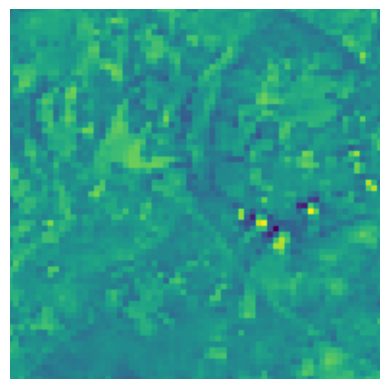

In [124]:

image_path = '/content/data/images/7.tif'
image = tiff.imread(image_path)

# Check if the image has multiple channels
if image.ndim == 3 and image.shape[2] > 4:
    # Select a single channel or combine channels as needed
    # For example, to display the first channel:
    image = image[:,:,0]
    # Or to average the first three channels (assuming they are RGB):

plt.imshow(image)
plt.axis('off')
plt.show()


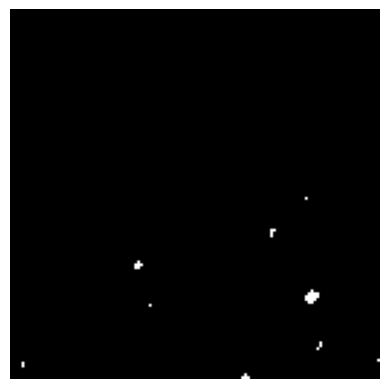

In [125]:


mask_path = '/content/data/labels/7.png'
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.show()


##Building Model

In [130]:

def conv_block(x, n_filters, dropout_rate=0.5):
    """two convolutions with Batch Normalization and Dropout"""
    x = Conv2D(n_filters, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(n_filters, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    if dropout_rate:
        x = Dropout(dropout_rate)(x)
    return x

def encoder_block(x, n_filters):
    """conv block and max pooling"""
    x = conv_block(x, n_filters)
    p = MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block(x, skip_features, n_filters):
    """upsample, skip connection, and conv block"""
    x = Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)

    # Resize skip_features to match x before concatenation
    if skip_features.shape[-1] != x.shape[-1]:
        skip_features = Conv2D(n_filters, (1, 1), padding='same')(skip_features)

    x = concatenate([x, skip_features])
    x = conv_block(x, n_filters)
    return x

def unet_model(n_classes, img_height, img_width, img_channels):
    inputs = Input((img_height, img_width, img_channels))

    # Contraction path, encoder
    c1, p1 = encoder_block(inputs, n_filters=64)
    c2, p2 = encoder_block(p1, n_filters=128)
    c3, p3 = encoder_block(p2, n_filters=256)
    c4, p4 = encoder_block(p3, n_filters=512)

    # Bottleneck
    bridge = conv_block(p4, n_filters=1024, dropout_rate=0.5)

    # Expansive path, decoder
    u4 = decoder_block(bridge, c4, n_filters=512)
    u3 = decoder_block(u4, c3, n_filters=256)
    u2 = decoder_block(u3, c2, n_filters=128)
    u1 = decoder_block(u2, c1, n_filters=64)

    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(u1)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

# إنشاء النموذج
model = unet_model(
    n_classes=2,
    img_height=128,
    img_width=128,
    img_channels=12
)


In [131]:
model.compile(loss="categorical_crossentropy",optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 128, 128, 12)   │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_76 (Conv2D)        │ (None, 128, 128, 64)   │          6,976 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_44    │ (None, 128, 128, 64)   │            256 │ conv2d_76[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_77 (Conv2D)        │ (None, 128, 128, 64)   │         36,928 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_45    │ (None, 128, 128, 64)   │            256 │ conv2d_77[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_18 (Dropout)      │ (None, 128, 128, 64)   │              0 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_16          │ (None, 64, 64, 64)     │              0 │ dropout_18[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_78 (Conv2D)        │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d_16[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_46    │ (None, 64, 64, 128)    │            512 │ conv2d_78[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_79 (Conv2D)        │ (None, 64, 64, 128)    │        147,584 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_47    │ (None, 64, 64, 128)    │            512 │ conv2d_79[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_19 (Dropout)      │ (None, 64, 64, 128)    │              0 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_17          │ (None, 32, 32, 128)    │              0 │ dropout_19[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_80 (Conv2D)        │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_17[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_48    │ (None, 32, 32, 256)    │          1,024 │ conv2d_80[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_81 (Conv2D)   

 Total params: 31,064,386 (118.50 MB)

 Trainable params: 31,050,690 (118.45 MB)

 Non-trainable params: 13,696 (53.50 KB)

In [132]:
earlystop = EarlyStopping(patience=10)

In [133]:
save_best_model = ModelCheckpoint('/content/drive/MyDrive/segmentation_model/img_segmentation.keras',
                                   save_best_only=True,
                                   monitor='val_loss',
                                   mode='min',
                                   verbose=1)
callbacks = [earlystop, save_best_model]

In [134]:

model.fit(train_dataset, epochs=50, validation_data=(val_images, val_masks), callbacks=callbacks)


Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4956 - loss: 1.0524   
Epoch 1: val_loss improved from inf to 2.07561, saving model to /content/drive/MyDrive/segmentation_model/img_segmentation.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 53s 4s/step - accuracy: 0.4964 - loss: 1.0440 - val_accuracy: 0.6712 - val_loss: 2.0756
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.4984 - loss: 0.8171
Epoch 2: val_loss did not improve from 2.07561
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 431ms/step - accuracy: 0.4987 - loss: 0.8151 - val_accuracy: 0.3637 - val_loss: 1510.0835
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.5045 - loss: 0.7537
Epoch 3: val_loss did not improve from 2.07561
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 423ms/step - accuracy: 0.5044 - loss: 0.7522 - val_accuracy: 0.4870 - val_loss: 5306.4629
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.4991 - loss: 0.7162
Epoch 4: val_loss did not improve from 2.07561
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 448ms/step - accu

## Load Model

In [136]:
model = load_model('/content/drive/MyDrive/segmentation_model/img_segmentation.keras')

In [137]:
test_loss, test_accuracy = model.evaluate(test_images, test_masks, batch_size=32)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.8491 - loss: 0.4438
Test Loss: 0.4475128650665283
Test Accuracy: 0.848336935043335


In [138]:

# Get predictions on the test set
predictions = model.predict(test_images)

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=-1)
true_labels = np.argmax(test_masks, axis=-1)

# Flatten the arrays
predicted_labels = predicted_labels.flatten()
true_labels = true_labels.flatten()

report = classification_report(true_labels, predicted_labels)

print(report)

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step
              precision    recall  f1-score   support

           0       0.86      0.96      0.91    597417
           1       0.73      0.42      0.53    156247

    accuracy                           0.85    753664
   macro avg       0.80      0.69      0.72    753664
weighted avg       0.84      0.85      0.83    753664



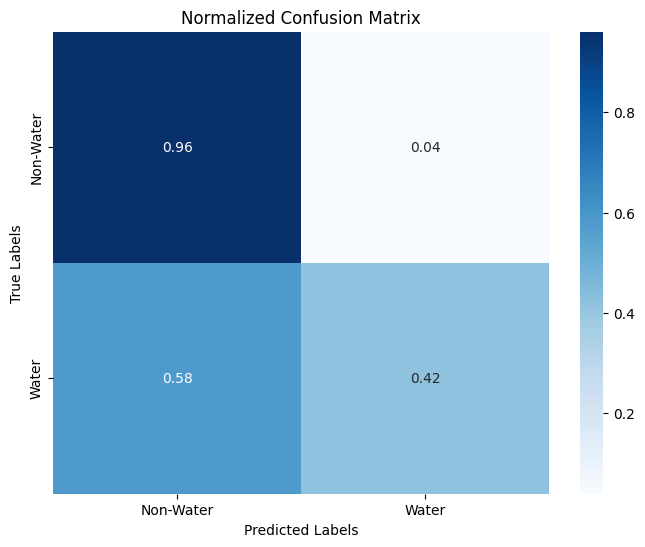

In [139]:
# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Normalize the confusion matrix
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the heatmap with normalized values
plt.figure(figsize=(8, 6))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues", xticklabels=['Non-Water', 'Water'], yticklabels=['Non-Water', 'Water'])
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()
